In [ ]:
import csv
import os.path
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from rbflayer import RBFLayer, InitCentersRandom
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

import matplotlib.pyplot as plt
import math

In [ ]:
# http://benalexkeen.com/feature-scaling-with-scikit-learn/
# https://github.com/PetraVidnerova/rbf_keras/blob/master/rbflayer.py

def load_dataset(is_normalize=True):
    global dataset, labels
    with open('OnlineNewsPopularity.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        next(reader) # skip the first row
        temp = []
        for idx, row in enumerate(reader):
            temp.append(row[1:])
        if is_normalize:
            # it is important which type of normalization method you use
            scaler = preprocessing.MinMaxScaler()
            temp = scaler.fit_transform(temp)
            print('Data is normalize')
        else:
            print('No normalize apply')
        for idx, row in enumerate(temp):
            slice_row = np.append(row[1:45], row[46:])
            labels.append(row[45])
            dataset.append(slice_row)
    return np.array(dataset), np.array(labels).reshape(len(labels), 1)

In [15]:
# Load dataset 
dataset = []
labels = []
# ori_dataset, ori_labels = load_dataset(is_normalize=False) 
dataset, labels = load_dataset(is_normalize=True)
print('Dataset shape: {0}, Labels: {1}'.format(dataset.shape, labels.shape))

x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=42)
print("x_train: {0}, y_train: {1}".format(x_train.shape, y_train.shape))
print("x_test: {0}, y_test: {1}".format(x_test.shape, y_test.shape))

Data is normalize
Dataset shape: (39644, 58), Labels: (39644, 1)
x_train: (31715, 58), y_train: (31715, 1)
x_test: (7929, 58), y_test: (7929, 1)


In [ ]:
print(x_train[0])
print(y_train[:20])

In [47]:
# https://www.youtube.com/watch?v=1Cw45yNm6VA
# build model
# beta - controls the drop off of circle. higher the beta the faster the circle will drop off. This will then affect the 
#        size of the circle, faster drop off will cause new circle to form.
#        (Drop of refers of gradient of circle, how smooth transit from circle area to non-circle area)
model = Sequential()
rbflayer = RBFLayer(58,
                    initializer=InitCentersRandom(x_train), 
                    betas=1.5,
                    input_shape=(58,))
model.add(rbflayer)
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mean_squared_error',
              optimizer=RMSprop(lr=0.001),
              metrics=['mse'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rbf_layer_18 (RBFLayer)      (None, 58)                3422      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 59        
Total params: 3,481
Trainable params: 3,481
Non-trainable params: 0
_________________________________________________________________


In [48]:
# training with callbacks
saved_weights_name = 'best_weights_rbf.h5'

# load weights if any
if os.path.isfile(saved_weights_name):
    model.load_weights(saved_weights_name)
    print("Weights loaded: {0}".format(saved_weights_name))

early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0.0001,
                           patience=10,
                           mode='min',
                           verbose=1)

checkpoint = ModelCheckpoint(saved_weights_name,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min',
                             period=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=4,
                              min_lr=0.00001,
                              verbose=1)
    
model.fit(x_train, y_train,
          epochs=50,
          validation_data=(x_test, y_test),
          callbacks=[early_stop, checkpoint, reduce_lr],
          verbose=1)

Train on 31715 samples, validate on 7929 samples
Epoch 1/50
31715/31715 [==============================] - 6s 180us/step - loss: 0.0244 - mean_squared_error: 0.0244 - val_loss: 0.0100 - val_mean_squared_error: 0.0100

Epoch 00001: val_loss improved from inf to 0.00996, saving model to best_weights_rbf.h5
Epoch 2/50
31715/31715 [==============================] - 7s 227us/step - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0077 - val_mean_squared_error: 0.0077

Epoch 00002: val_loss improved from 0.00996 to 0.00772, saving model to best_weights_rbf.h5
Epoch 3/50
31715/31715 [==============================] - 7s 226us/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0067 - val_mean_squared_error: 0.0067

Epoch 00003: val_loss improved from 0.00772 to 0.00666, saving model to best_weights_rbf.h5
Epoch 4/50
31715/31715 [==============================] - 6s 201us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0059 - val_mean_squared_error: 0.0059

Epo


Epoch 00034: val_loss did not improve
Epoch 35/50
31715/31715 [==============================] - 7s 207us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0022 - val_mean_squared_error: 0.0022

Epoch 00035: val_loss did not improve

Epoch 00035: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 36/50
31715/31715 [==============================] - 7s 207us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0020 - val_mean_squared_error: 0.0020

Epoch 00036: val_loss improved from 0.00212 to 0.00205, saving model to best_weights_rbf.h5
Epoch 37/50
31715/31715 [==============================] - 7s 210us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0021 - val_mean_squared_error: 0.0021

Epoch 00037: val_loss did not improve
Epoch 38/50
31715/31715 [==============================] - 7s 213us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0020 - val_mean_squared_error: 0.0020

Epoch 00038: val_loss did not i

7929/7929 [==============================] - 1s 89us/step
loss: 0.002039
mean_squared_error: 0.002039
explained_variance_score: 0.790636
mean_absolute_error: 0.028721
mean_squared_log_error: 0.001144
median_absolute_error: 0.01822
r2_score: 0.790596


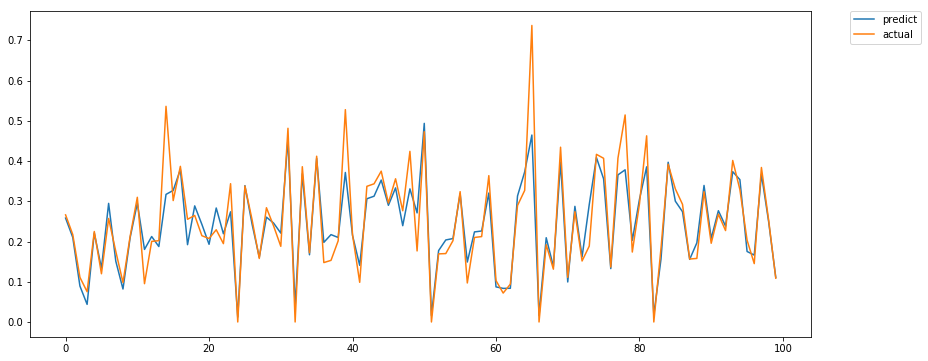

In [49]:
# showing results
scores = model.evaluate(x_test, y_test)
print("{0}: {1}".format(model.metrics_names[0], round(scores[0], 6)))
print("{0}: {1}".format(model.metrics_names[1], round(scores[1], 6)))

# http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
y_pred = model.predict(x_test)
var_score = explained_variance_score(y_pred, y_test)
mean_abs_error = mean_absolute_error(y_pred, y_test)
mean_sqare_log_error = mean_squared_log_error(y_pred, y_test)
median_abs_error = median_absolute_error(y_pred, y_test)
r2 = r2_score(y_pred, y_test)
print('explained_variance_score: {0}'.format(round(var_score, 6)))
print('mean_absolute_error: {0}'.format(round(mean_abs_error, 6)))
print('mean_squared_log_error: {0}'.format(round(mean_sqare_log_error, 6)))
print('median_absolute_error: {0}'.format(round(median_abs_error, 6)))
print('r2_score: {0}'.format(round(r2, 6)))

plt.figure(figsize=(14,6))
plt.plot(y_pred[:100], label="predict")
plt.plot(y_test[:100], label="actual")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()